# Reassignment Tutorial for SM and ST Data

The purpose of this tutorial is to demonstrate the process of reassigning spatial transcriptomics (ST) and spatial metabolomics (SM) data to achieve accurate correspondence at each spatial spot. The differing resolutions of detection methods used in ST and SM hinder accurate correspondence, but this can be overcome using the reassignment function from the spatialMETA package.

Import necessary packages and libraries

In [1]:
cd ..

/home/rolan/Documents/spatialMETA


/home/rolan/miniconda3/envs/spatialtk/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import spatialmeta as smt
import numpy as np
import pandas as pd
import scanpy as sc
from pyimzml.ImzMLParser import ImzMLParser

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import warnings
warnings.filterwarnings("ignore")

## Read and preprocess data

### Read SM data

In [5]:
# If data is available
adata_SM_aligned = sc.read_h5ad("./spatialmeta_tutorial/data/Y7_T_adata_SM_raw.aligned.h5ad")
adata_SM = sc.read_h5ad("./spatialmeta_tutorial/data/Y7_T_adata_SM_raw.h5ad")

In [6]:
#Test data can be obtained from SpatialMETA
adata_SM_aligned = smt.data.load_adata(
    sample_name="Y7_T_raw.aligned",
    modality="SM"
)
adata_SM = smt.data.load_adata(
    sample_name="Y7_T_raw",
    modality="SM"
)

/home/rolan/Documents/spatialMETA/spatialmeta/data/./datasets/adata_SM_Y7_T_raw.aligned_raw.h5ad


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 98 24.6M   98 24.2M    0     0   332k      0  0:01:16  0:01:14  0:00:02  972k

/home/rolan/Documents/spatialMETA/spatialmeta/data/./datasets/adata_SM_Y7_T_raw_raw.h5ad


100 24.6M  100 24.6M    0     0   336k      0  0:01:15  0:01:15 --:--:--  977k


In [9]:
adata_SM.obsm = adata_SM_aligned.obsm

In [10]:
adata_SM

AnnData object with n_obs × n_vars = 10649 × 1299
    obs: 'x_coord_original', 'y_coord_original', 'total_intensity_pos', 'mean_intensity_pos', 'total_intensity_neg', 'mean_intensity_neg', 'spot_index', 'total_intensity', 'mean_intensity'
    var: 'name', 'type'
    uns: 'spatial'
    obsm: 'spatial', 'spatial_normalized', 'spatial_transformed'

In [9]:
smt.pp.calculate_qc_metrics_sm(adata_SM)
adata_SM = smt.pp.filter_cells_sm(adata_SM,min_total_intensity=2e6)

Filtered 234 cells with total intensity less than 2000000.0


### Read ST data

In [10]:
# If data is available
adata_ST = sc.read_h5ad("./spatialmeta_tutorial/data/Y7_T_adata_ST_qc.h5ad")

In [7]:
#Test data can be obtained from SpatialMETA
adata_ST = smt.data.load_adata(
    sample_name="Y7_T_raw",
    modality="ST"
)

/home/rolan/Documents/spatialMETA/spatialmeta/data/./datasets/adata_ST_Y7_T_raw_raw.h5ad


In [11]:
adata_ST

AnnData object with n_obs × n_vars = 1914 × 36404
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

### Project H&E image into SM data

In [12]:
name = 'Y7_T'
adata_SM.obsm['spatial_transformed_scaled'] = adata_SM.obsm['spatial_transformed']/adata_ST.uns['spatial'][name]['scalefactors']['tissue_hires_scalef']
adata_SM.obsm['spatial'] = adata_SM.obsm['spatial_transformed_scaled']
adata_SM.uns['spatial'] = adata_ST.uns['spatial']

[<Axes: title={'center': 'total_intensity'}, xlabel='spatial1', ylabel='spatial2'>]

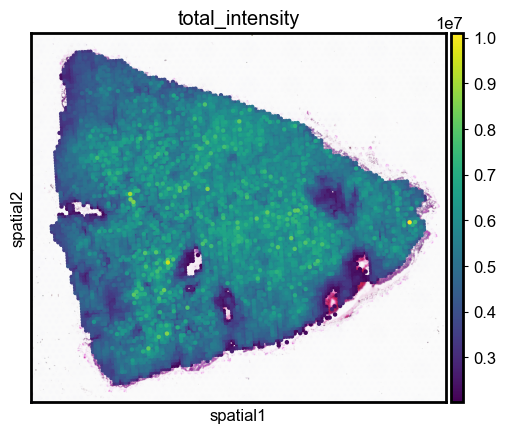

In [13]:
sc.pl.spatial(adata_SM, 
              img_key="hires", 
              color=["total_intensity"],
              show=False)

## Reassignment

After aligning the Spatial Transcriptomics (ST) and Spatial Metabolomics (SM) data, the spatial positions of the ST spots are extracted and reassigned as the new coordinates for the SM data. To establish a correspondence between these new SM spots and the original raw SM data, a K-nearest neighbor (KNN) calculation is performed by `spot_align_byknn()` function. The process consists of the following steps:
1. KNN Calculation:
For each newly assigned SM spatial position (aligned with ST spots), the K nearest raw SM spots are identified based on Euclidean distance. By default, K is set to 5, but users can modify this parameter as needed. A higher K value incorporates more neighboring raw SM spots, leading to a smoother distribution of the Metabolite Intensity Matrix (MIM) in the reassigned SM data.
2. Distance Threshold Filtering:
To ensure that only nearby SM spots are included in the KNN calculation, a distance threshold is applied, filtering out those too far from the reassigned SM spot. This threshold is determined as the product of min_dist and dist_fold, where min_dist represents the minimum inter-spot distance in the ST data, computed via the `calculate_min_dist()` function (recommended) or manually defined by the user. dist_fold is a scaling factor with a default value of 1.5, which can also be user-defined.
3. MIM Computation:
Once the K nearest raw SM spots are identified, the MIM value for each new SM spot is computed as the average of its K nearest neighbors from the raw SM data.

### Resample in shared locations

In [15]:
ST_dot_in_df = smt.pp.ST_spot_sample(adata_ST, "spatial")

In [16]:
min_dist = smt.pp.calculate_min_dist(adata_ST)
print(min_dist)

366.0054644400818


### New SM and ST data after reassignment

In [17]:
adata_SM_new, adata_ST_new = smt.pp.spot_align_byknn(ST_dot_in_df,
                             adata_SM,
                             adata_ST,
                             min_dist=min_dist,
                             dist_fold=1.5)

In [18]:
smt.pp.calculate_qc_metrics_sm(adata_SM_new)

### visualization for new SM and ST data

[<Axes: title={'center': 'total_counts'}, xlabel='spatial1', ylabel='spatial2'>]

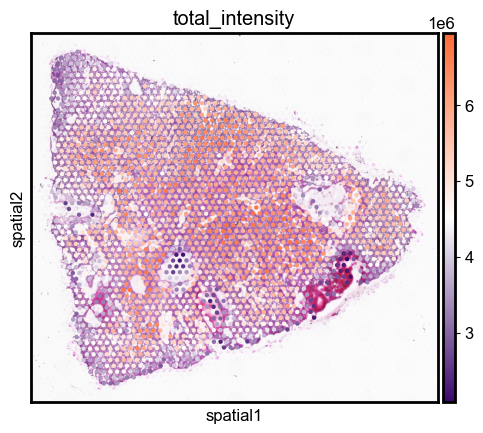

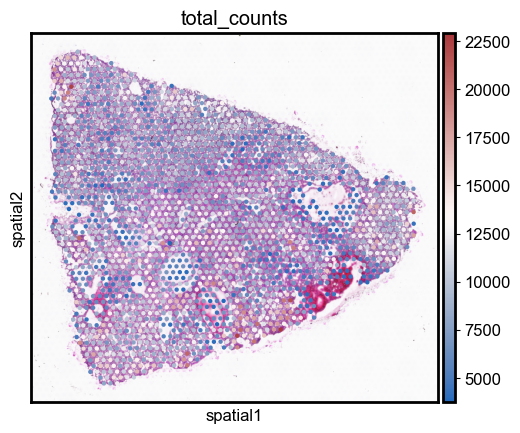

In [19]:
sc.pl.spatial(adata_SM_new, 
          img_key="hires", 
          color=["total_intensity"],
         #color_map = "vlag",
              cmap = smt.pl.make_colormap(['#3c096c','#FFFFFF','#ff6b35']),
          show=False)
sc.pl.spatial(adata_ST, 
          img_key="hires", 
          color=["total_counts"],
          color_map = "vlag",
          show=False)

## Joint ST and SM into one h5ad

### Quality control

<Axes: xlabel='mean_intensity', ylabel='Count'>

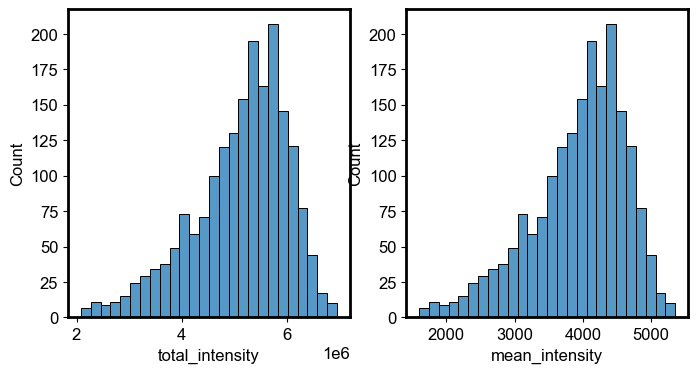

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.histplot(
    adata_SM_new.obs["total_intensity"], 
    kde=False, 
    ax=axs[0]
)
sns.histplot(
    adata_SM_new.obs["mean_intensity"],
    kde=False,
    ax=axs[1],
)

In [21]:
adata_SM_new = smt.pp.filter_cells_sm(adata_SM_new,min_total_intensity=2e6)

Filtered 0 cells with total intensity less than 2000000.0


In [24]:
adata_ST.obs['x_coord'] = adata_ST_new.obs['x_coord'].values
adata_ST.obs['y_coord'] = adata_ST_new.obs['y_coord'].values
adata_ST.obs['spot_name'] = adata_ST_new.obs['spot_name'].values

In [25]:
adata_SM_new.write_h5ad("./spatialmeta_tutorial/data/Y7_T_adata_SM_raw_reassign.h5ad")
adata_ST.write_h5ad("./spatialmeta_tutorial/data/Y7_T_adata_SM_raw_reassign.h5ad")

### Joint ST and SM data

In [29]:
joint_adata = smt.pp.joint_adata_sm_st(
    adata_SM_new = adata_SM_new,
    adata_ST_new = adata_ST
)

[<Axes: title={'center': 'total_counts'}, xlabel='spatial1', ylabel='spatial2'>]

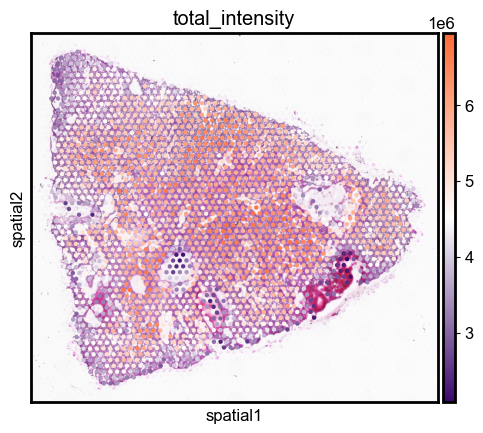

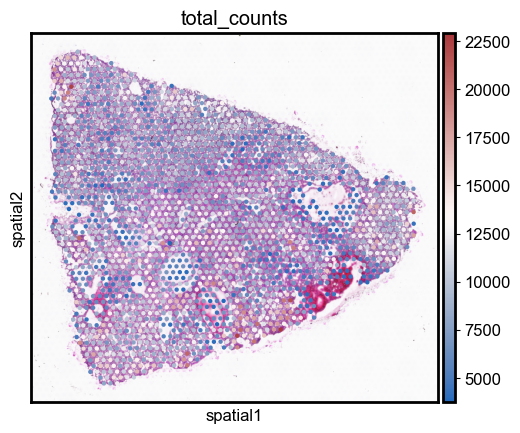

In [30]:
sc.pl.spatial(
    joint_adata, 
    img_key="hires", 
    color=["total_intensity"],
    cmap = smt.pl.make_colormap(['#3c096c','#FFFFFF','#ff6b35']),
    show=False
)
sc.pl.spatial(
    joint_adata, 
    img_key="hires", 
    color=["total_counts"],
    color_map = "vlag",
    show=False
)

Save the joint data as an h5ad file

In [31]:
joint_adata.write_h5ad("./spatialmeta_tutorial/data/Y7_T_adata_joint_raw.h5ad")